# EDA Mortality in Colombia


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

We have the DANE information fo 2017 and 2018 mortality reported in Colombia translated previously for column names and infectious deseases in the column 'CAU_HOMOL' into parquet format.

In [2]:
df17 = pd.read_parquet("../parquet_datasets/nofetal2017_new.parquet")
df18 = pd.read_parquet("../parquet_datasets/nofetal2018_new.parquet")
dfdem=pd.read_parquet("../parquet_datasets/proyecciones_poblacion_departamental_2018-2050.parquet")

## Mortality information

In [3]:
print("17: ", df17.shape)
print("18: ",df18.shape)

17:  (227624, 70)
18:  (236932, 66)


We noticed that the datasets do not have the same number of columns. Furthermore, not all the columns are needed for our purpose. Then we have to select the columns and merge the dataframes of each year

Dictionary link: 
http://microdatos.dane.gov.co/index.php/catalog/652/data_dictionary#page=F10&tab=data-dictionary

In [4]:
#Check information
df17.columns 

Index(['Unnamed: 0', 'COD_DPTO', 'COD_MUNIC', 'A_DEFUN', 'SIT_DEFUN',
       'OTRSITIODE', 'COD_INST', 'NOM_INST', 'TIPO_DEFUN', 'ANO', 'MES',
       'HORA', 'MINUTOS', 'SEXO', 'EST_CIVIL', 'GRU_ED1', 'GRU_ED2',
       'NIVEL_EDU', 'ULTCURFAL', 'MUERTEPORO', 'SIMUERTEPO', 'OCUPACION',
       'IDPERTET', 'CODPRES', 'CODPTORE', 'CODMUNRE', 'AREA_RES', 'SEG_SOCIAL',
       'IDADMISALU', 'IDCLASADMI', 'PMAN_MUER', 'CONS_EXP', 'MU_PARTO',
       'T_PARTO', 'TIPO_EMB', 'T_GES', 'PESO_NAC', 'EDAD_MADRE', 'N_HIJOSV',
       'N_HIJOSM', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'EMB_FAL', 'EMB_SEM',
       'EMB_MES', 'MAN_MUER', 'CODOCUR', 'CODMUNOC', 'C_MUERTE', 'C_MUERTEB',
       'C_MUERTEC', 'C_MUERTED', 'C_MUERTEE', 'ASIS_MED', 'C_DIR1', 'C_DIR12',
       'C_ANT1', 'C_ANT12', 'C_ANT2', 'C_ANT22', 'C_ANT3', 'C_ANT32', 'C_PAT1',
       'C_PAT2', 'C_BAS1', 'C_MCM1', 'CAUSA_666', 'IDPROFCER', 'CAU_HOMOL'],
      dtype='object')

In [5]:
#Check information in the largest dataset
#for i in df17.columns:
 #   print(i,":\n",df17[i].unique())

There are some things to adjust in the datasets before visualizing the information:

1. Select the columns of interest.
2. Create a column with date in datetype format.
3. Replace ' '  values for NaN for later cleaning.
4. Change the column name 'COD_DPTO' for 'Dpto' because it does not have codes but names of the Colombian departments.

In [6]:
 #Keep the columns of interest
columns=['COD_DPTO','A_DEFUN','SIT_DEFUN','ANO', 'MES','SEXO', 'GRU_ED1', 'GRU_ED2',
         'MUERTEPORO','IDPERTET','SEG_SOCIAL','PMAN_MUER','CONS_EXP','CAU_HOMOL']
df2=df17[columns].append(df18[columns])

#Create date column and set it as index
meses={'Enero':1,'Febrero':2,'Marzo':3,'Abril':4,'Mayo':5,'Junio':6,'Julio':7,
      'Agosto':8,'Septiembre':9, 'Octubre':10,'Noviembre':11,'Diciembre':12}
df2['FECHA']=pd.to_datetime(df2.ANO*10000+df2.MES.map(meses)*100+1,format='%Y%m%d')

#Fill blanks with nulls (to be checked)
df2=df2.replace(r'^\s+$', np.nan, regex=True)
df2.set_index('FECHA',inplace=True)

#Change Column name
df2.rename(columns={'COD_DPTO':'Dpto'},inplace=True)
df2.head()

,Dpto,A_DEFUN,SIT_DEFUN,ANO,MES,SEXO,GRU_ED1,GRU_ED2,MUERTEPORO,IDPERTET,SEG_SOCIAL,PMAN_MUER,CONS_EXP,CAU_HOMOL
FECHA,,,,,,,,,,,,,,
2017-01-01,Putumayo,Cabecera municipal,Hospital/clínica,2017,Enero,Masculino,De 50 a 54 años,De 45 a 64 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101
2017-01-01,Putumayo,Cabecera municipal,Vía pública,2017,Enero,Masculino,De 25 a 29 años,De 15 a 44 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101
2017-01-01,Antioquia,Cabecera municipal,Hospital/clínica,2017,Enero,Masculino,De 35 a 39 años,De 15 a 44 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101
2017-01-01,Antioquia,Rural disperso,Vía pública,2017,Enero,Masculino,De 45 a 49 años,De 45 a 64 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101
2017-01-01,Cauca,Rural disperso,Vía pública,2017,Enero,Masculino,De 30 a 34 años,De 15 a 44 años,2,Ninguno de las anteriores,Subsidiado,Violenta,Médico legista,101


##### Edit the CAU_HOMOL column (causes of death)

There are so many causes that are still with codified values and not all the infectious deseases are of our particular interest. Additionally, the acute respiratory infection is in the cathegory '62' (other respiratory deseases). Thus, we create groups by deseases of interest, group all the other deseases in 'No infecciosas' and add the respiratory deseases.

In [7]:
# Cathegorical Variable: 'Infecciosas'
df2['Infecciosas']=np.where(df2.CAU_HOMOL.str.isnumeric(),0,1)

#ADD cause 62 with probably acute respiratory infection
df2.loc[df2.CAU_HOMOL=='62','CAU_HOMOL']='Respiratorias'

# Cathegorical Variable: 'Infecciosas2' (includes respiratory)
df2['Infecciosas2']=np.where(df2.CAU_HOMOL.str.isnumeric(),0,1)

#Others are not infectious deseases
df2.loc[df2.CAU_HOMOL.str.isnumeric(),'CAU_HOMOL']='No Infecciosas'

#Infectious deseases for the analysis
df2['Infecciosas3']=np.where(df2.CAU_HOMOL.isin(['Ciertas enfermedades transmitidas por vectores y rabia','Respiratorias']),1,0)

In [8]:
#Check information
for i in df2.columns:
    print(i,":\n",df2[i].unique())

Dpto :
 ['Putumayo' 'Antioquia' 'Cauca' 'Boyaca' 'Nariño' 'Cordoba' 'Cundinamarca'
 'Valle del Cauca' 'Caldas' 'Sucre' 'Quindio' 'Bogotá' 'Cesar' 'Tolima'
 'Huila' 'Magdalena' 'Bolivar' 'Atlántico' 'Santander' 'Casanare'
 'Norte de Santander' 'Risaralda' 'Arauca' 'Meta' 'Caqueta' 'La guajira'
 'Choco' 'Guainía' 'Guaviare'
 'Archipiélago de San Andrés, Providencia y Santa Catalina' 'Vichada'
 'Amazonas' 'Vaupés']
A_DEFUN :
 ['Cabecera municipal' 'Rural disperso'
 'Centro poblado (Inspección, corregimiento o caserío)' 'Sin información']
SIT_DEFUN :
 ['Hospital/clínica' 'Vía pública' 'Casa /domicilio' 'Otro'
 'Lugar de trabajo' 'Centro /puesto de salud' 'Sin información']
ANO :
 [2017 2018]
MES :
 ['Enero' 'Febrero' 'Marzo' 'Abril' 'Mayo' 'Junio' 'Julio' 'Agosto'
 'Septiembre' 'Noviembre' 'Octubre' 'Diciembre']
SEXO :
 ['Masculino' 'Femenino' 'Indeterminado']
GRU_ED1 :
 ['De 50 a 54 años' 'De 25 a 29 años' 'De 35 a 39 años' 'De 45 a 49 años'
 'De 30 a 34 años' 'De 75 a 79 años' 'De 90 a 9

##### Null values

In [9]:
df2.isnull().sum()

Dpto                0
A_DEFUN             0
SIT_DEFUN           0
ANO                 0
MES                 0
SEXO                0
GRU_ED1             0
GRU_ED2             0
MUERTEPORO      17481
IDPERTET            0
SEG_SOCIAL          0
PMAN_MUER           0
CONS_EXP            0
CAU_HOMOL           0
Infecciosas         0
Infecciosas2        0
Infecciosas3        0
dtype: int64

In [10]:
# Change null values
df2.MUERTEPORO.fillna(9,inplace=True) #9 :sin información
df2.isna().sum()

Dpto            0
A_DEFUN         0
SIT_DEFUN       0
ANO             0
MES             0
SEXO            0
GRU_ED1         0
GRU_ED2         0
MUERTEPORO      0
IDPERTET        0
SEG_SOCIAL      0
PMAN_MUER       0
CONS_EXP        0
CAU_HOMOL       0
Infecciosas     0
Infecciosas2    0
Infecciosas3    0
dtype: int64

#### Plot Infectious Desease per Year

Plot death toll in total by infectious deseases.


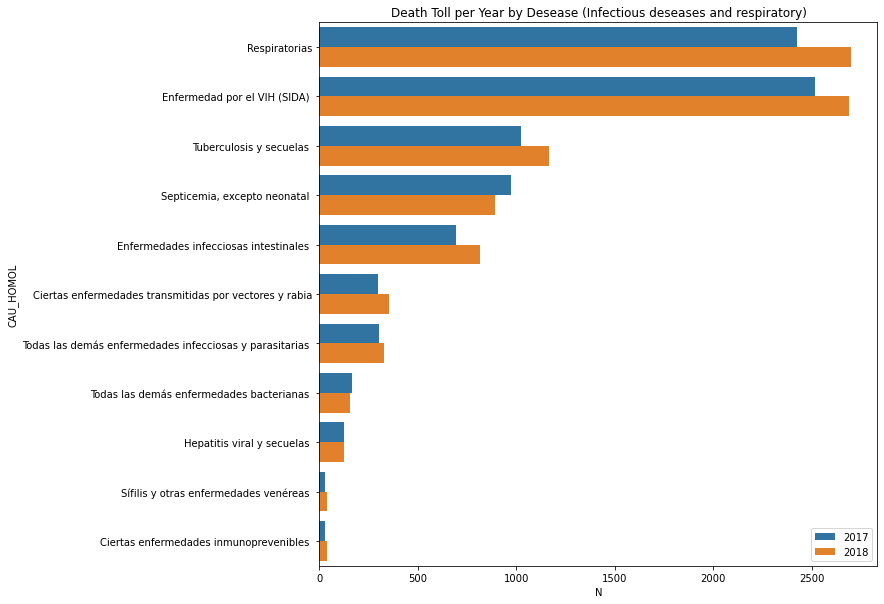

In [11]:
temp=df2[df2.Infecciosas2==1][['CAU_HOMOL','ANO','MES']].rename(columns={'MES':'N'})\
.groupby(['CAU_HOMOL','ANO']).count().reset_index().sort_values(by=['N'],ascending=False)
fig = plt.figure(figsize=(10,10))
sns.barplot(data=temp, x="N", y="CAU_HOMOL",hue="ANO")
plt.legend(loc='lower right')
plt.title('Death Toll per Year by Desease (Infectious deseases and respiratory)');

##### Time series plot of monthly deaths by desease

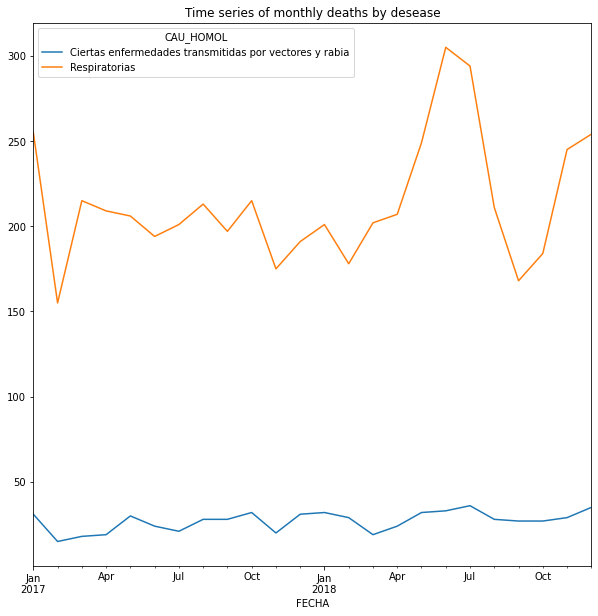

In [12]:
#Plot of Desease Number by years
df2[df2.Infecciosas3==1].reset_index().groupby(['FECHA','CAU_HOMOL']).count()['Dpto'].unstack('CAU_HOMOL').fillna(0)\
.plot.line(figsize=(10,10))
plt.title('Time series of monthly deaths by desease');

In [13]:
df3=df2[df2.Infecciosas3==1].reset_index().groupby(['FECHA','CAU_HOMOL']).count()['Dpto'].reset_index().fillna(0).rename(columns={'Dpto':'Total'})
df3['AÑO']=df3['FECHA'].dt.year
df3.groupby(['CAU_HOMOL','AÑO']).sum().groupby('CAU_HOMOL').mean()

,Total
CAU_HOMOL,
Ciertas enfermedades transmitidas por vectores y rabia,324
Respiratorias,2562


In the period from May to August of 2018 there is a peak of respiratory desease deaths. 

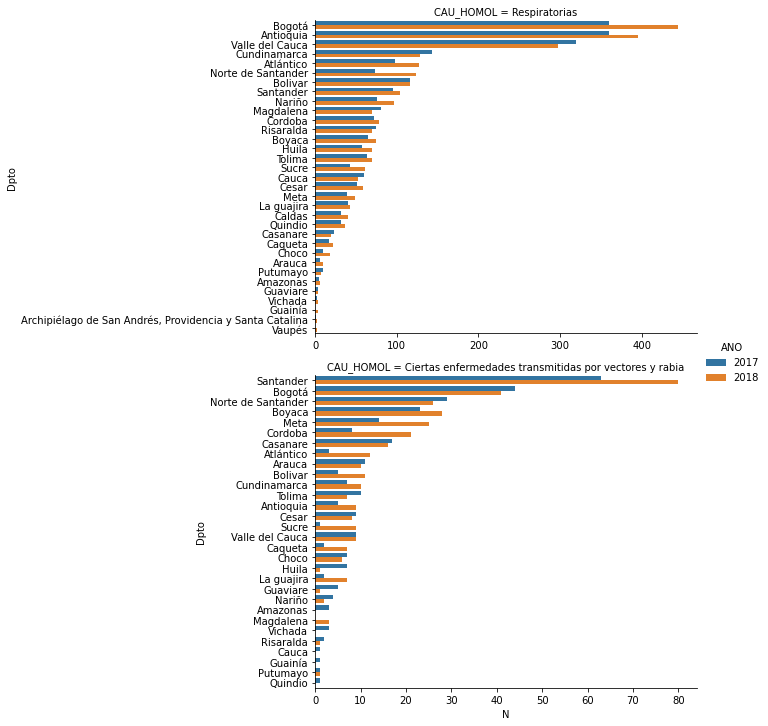

In [14]:
temp=df2[df2.Infecciosas3==1][['CAU_HOMOL','ANO','MES','Dpto']].rename(columns={'MES':'N'})\
.groupby(['Dpto','ANO','CAU_HOMOL']).agg({'N':'count'}).reset_index().sort_values(by=['CAU_HOMOL','N'], ascending= False)

g = sns.catplot(data=temp, x='N', y='Dpto', hue='ANO', row='CAU_HOMOL',
                kind='bar', sharex=False, sharey= False, height=5, aspect=2);

## Demographic Information 

In [15]:
dfdem2=dfdem[['Total Hombres','Total Mujeres','Total']]
dfdem

,DP,DPNOM,AÑO,ÁREA GEOGRÁFICA,Hombres_0,Hombres_1,Hombres_2,Hombres_3,Hombres_4,Hombres_5,...,Total_94,Total_95,Total_96,Total_97,Total_98,Total_99,Total_100 y más,Total Hombres,Total Mujeres,Total
0,5,Antioquia,2018,Cabecera Municipal,31398,31674,31916,32172,32460,32748,...,1766,1456,1168,1075,998,1103,2734,2351655,2621286,4972941
1,5,Antioquia,2018,Centros Poblados y Rural Disperso,14488,14314,14164,14027,13878,13742,...,477,360,308,273,217,276,524,742504,691657,1434161
2,5,Antioquia,2018,Total,45886,45988,46080,46199,46338,46490,...,2243,1816,1476,1348,1215,1379,3258,3094159,3312943,6407102
3,5,Antioquia,2019,Cabecera Municipal,32581,32652,32860,33074,33261,33471,...,1881,1571,1279,1028,987,949,2905,2430652,2703086,5133738
4,5,Antioquia,2019,Centros Poblados y Rural Disperso,14220,14033,13938,13829,13711,13603,...,449,380,288,260,188,258,472,734351,682117,1416468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3262,99,Vichada,2049,Centros Poblados y Rural Disperso,1251,1240,1233,1227,1225,1218,...,18,16,10,9,5,4,5,67013,61660,128673
3263,99,Vichada,2049,Total,1407,1402,1397,1397,1397,1394,...,27,21,15,10,9,8,5,81420,75604,157024
3264,99,Vichada,2050,Cabecera Municipal,154,159,164,166,173,174,...,8,8,4,4,1,4,2,14384,13898,28282
3265,99,Vichada,2050,Centros Poblados y Rural Disperso,1252,1242,1234,1229,1223,1224,...,22,15,12,8,6,5,6,67745,62357,130102


In [16]:
# n18=pd.read_csv("Data/nac2018/nac2018.csv", sep=";")

In [17]:
# Deptos={ 5:' Antioquia', 8: ' Atlántico', 11: ' Bogotá', 13: ' Bolivar', 15: ' Boyaca', 17: 'Caldas', 18: ' Caqueta', 19: 'Cauca', 20: ' Cesar', 23: ' Cordoba', 25: 'Cundinamarca', 27: ' Choco', 41: ' Huila', 44: ' La guajira', 47: ' Magdalena', 50: ' Meta', 52: ' Nariño', 54: ' Norte de Santander', 63: ' Quindio', 66: ' Risaralda', 68: ' Santander', 70: ' Sucre', 73: ' Tolima', 76: ' Valle del Cauca', 81: ' Arauca', 85: ' Casanare', 86: ' Putumayo', 88: ' Archipiélago de San Andrés, Providencia y Santa Catalina', 91: ' Amazonas', 94: ' Guainía', 95: ' Guaviare', 97: ' Vaupés', 99: ' Vichada'}
# n18['Dpto']=n18['COD_DPTO'].replace(Deptos)
# n18

In [18]:
print('Demog:\n',dfdem.DPNOM.unique())
# print('Nac18:\n',n18.Dpto.unique())
print('Nofetal:\n',df2.Dpto.unique())

Demog:
 ['Antioquia' 'Atlántico' 'Bogotá, D.C.' 'Bolívar' 'Boyacá' 'Caldas'
 'Caquetá' 'Cauca' 'Cesar' 'Córdoba' 'Cundinamarca' 'Chocó' 'Huila'
 'La Guajira' 'Magdalena' 'Meta' 'Nariño' 'Norte de Santander' 'Quindio'
 'Quindío' 'Risaralda' 'Santander' 'Sucre' 'Tolima' 'Valle del Cauca'
 'Arauca' 'Casanare' 'Putumayo' 'Archipiélago de San Andrés'
 'Archipiélago de San Andrés, Providencia y Santa Catalina' 'Amazonas'
 'Guainía' 'Guaviare' 'Vaupés' 'Vichada']
Nofetal:
 ['Putumayo' 'Antioquia' 'Cauca' 'Boyaca' 'Nariño' 'Cordoba' 'Cundinamarca'
 'Valle del Cauca' 'Caldas' 'Sucre' 'Quindio' 'Bogotá' 'Cesar' 'Tolima'
 'Huila' 'Magdalena' 'Bolivar' 'Atlántico' 'Santander' 'Casanare'
 'Norte de Santander' 'Risaralda' 'Arauca' 'Meta' 'Caqueta' 'La guajira'
 'Choco' 'Guainía' 'Guaviare'
 'Archipiélago de San Andrés, Providencia y Santa Catalina' 'Vichada'
 'Amazonas' 'Vaupés']


In [19]:
# n18.Dpto=n18.Dpto.str.strip()
# n18.Dpto.unique()

In [20]:
# import unicodedata
# def strip_accents(s):
#    return ''.join(c for c in unicodedata.normalize('NFD', s)
#                   if unicodedata.category(c) != 'Mn')

In [21]:
# n18.Dpto=n18.Dpto.apply(strip_accents)
# dfdem.DPNOM=dfdem.DPNOM.apply(strip_accents)
# df2.Dpto=df2.Dpto.apply(strip_accents)

In [22]:
dfdem.DPNOM=dfdem.DPNOM.replace({'Archipiélago de San Andrés, Providencia y Santa Catalina':'San Andrés y Providencia'})
dfdem.DPNOM.unique()

array(['Antioquia', 'Atlántico', 'Bogotá, D.C.', 'Bolívar', 'Boyacá',
       'Caldas', 'Caquetá', 'Cauca', 'Cesar', 'Córdoba', 'Cundinamarca',
       'Chocó', 'Huila', 'La Guajira', 'Magdalena', 'Meta', 'Nariño',
       'Norte de Santander', 'Quindio', 'Quindío', 'Risaralda',
       'Santander', 'Sucre', 'Tolima', 'Valle del Cauca', 'Arauca',
       'Casanare', 'Putumayo', 'Archipiélago de San Andrés',
       'San Andrés y Providencia', 'Amazonas', 'Guainía', 'Guaviare',
       'Vaupés', 'Vichada'], dtype=object)

In [23]:
df2.CAU_HOMOL.unique()

array(['No Infecciosas', 'Enfermedad por el VIH (SIDA) ', 'Respiratorias',
       'Septicemia, excepto neonatal ',
       'Todas las demás enfermedades infecciosas y parasitarias ',
       'Tuberculosis y secuelas ',
       'Enfermedades infecciosas intestinales ',
       'Todas las demás enfermedades bacterianas ',
       'Ciertas enfermedades transmitidas por vectores y rabia',
       'Hepatitis viral y secuelas ',
       'Sífilis y otras enfermedades venéreas ',
       'Ciertas enfermedades inmunoprevenibles '], dtype=object)

In [24]:
df2.GRU_ED2.unique()

array(['De 45 a 64 años', 'De 15 a 44 años', 'De 65 y mas años',
       'De 1 a 4 años', 'De 5 a 14 años', 'Edad desconocida',
       'Menor de 1 año'], dtype=object)

In [25]:
df3=df2[['Dpto','SEXO','GRU_ED1']].reset_index()

In [26]:
g04=['Menor de una hora','Menor de un día', 'De 1 a 6 días','De 7 a 27 días','De 28 a 29 días',
   'De 1 a 5 meses','De 6 a 11 meses','De 1 año', 'De 2 a 4 años']
df3.loc[ df3.GRU_ED1.isin(g04),'GRU_ED1']='De 0 a 4 años'
df3.GRU_ED1.unique()
df3.Dpto=df3.Dpto.replace({'Archipiélago de San Andrés, Providencia y Santa Catalina':'San Andrés y Providencia'})

In [27]:
df3.to_parquet('../parquet_datasets/Nofetal_S.parquet')